In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gym
from gym import spaces

df = pd.read_csv('healthcare-dataset-stroke-data.csv')  

print("First few rows of the dataset:")
print(df.head())

df['hypertension'] = df['hypertension'].astype('object')
df['heart_disease'] = df['heart_disease'].astype('object')
df['stroke'] = df['stroke'].astype('object')

df.drop('id', axis=1, inplace=True)

print("Summary statistics:")
print(df.describe())

print("Data types:")
print(df.dtypes)

print("Checking for NaN or null values:")
print(df.isnull().sum())


First few rows of the dataset:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
Summary statistics:
     

In [2]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
for column in categorical_cols:
    df[column].fillna(df[column].mode()[0], inplace=True)

print("Checking for NaN or null values after filling:")
print(df.isnull().sum())


Checking for NaN or null values after filling:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [3]:

print("Summary statistics:")
print(df.describe())

print("Data types:")
print(df.dtypes)

Summary statistics:
               age  avg_glucose_level          bmi
count  5110.000000        5110.000000  5110.000000
mean     43.226614         106.147677    28.893237
std      22.612647          45.283560     7.698018
min       0.080000          55.120000    10.300000
25%      25.000000          77.245000    23.800000
50%      45.000000          91.885000    28.400000
75%      61.000000         114.090000    32.800000
max      82.000000         271.740000    97.600000
Data types:
gender                object
age                  float64
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                object
dtype: object


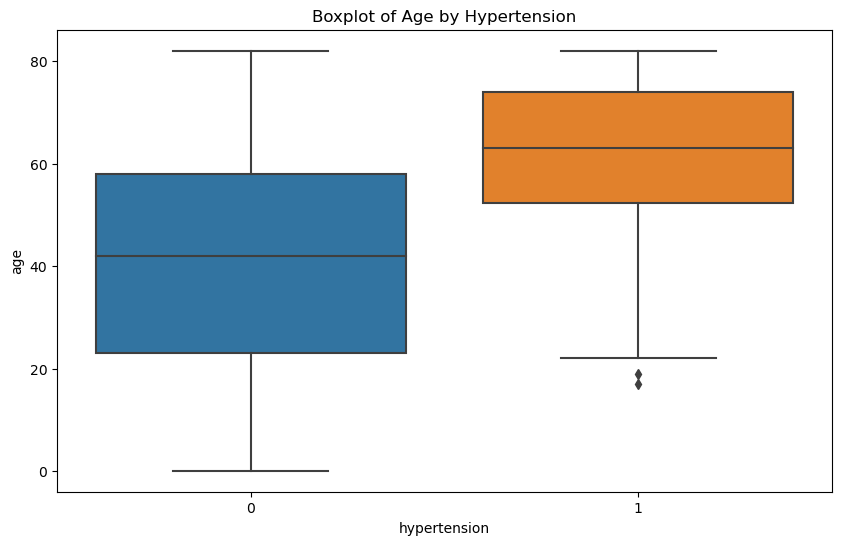

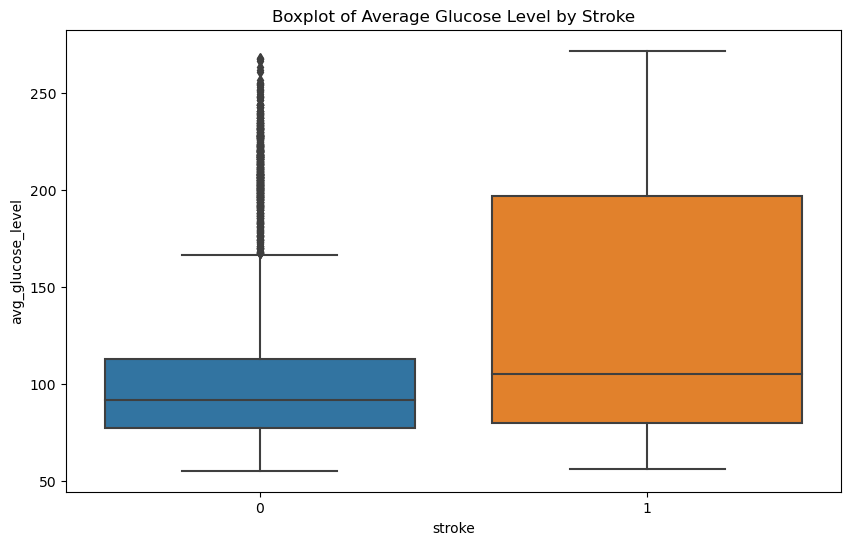

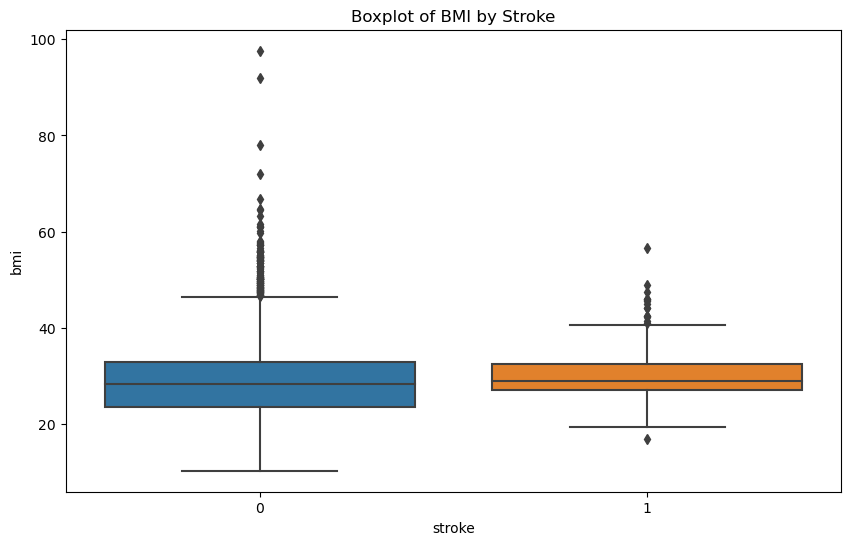

In [4]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='hypertension', y='age', data=df)
plt.title('Boxplot of Age by Hypertension')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
plt.title('Boxplot of Average Glucose Level by Stroke')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title('Boxplot of BMI by Stroke')
plt.show()


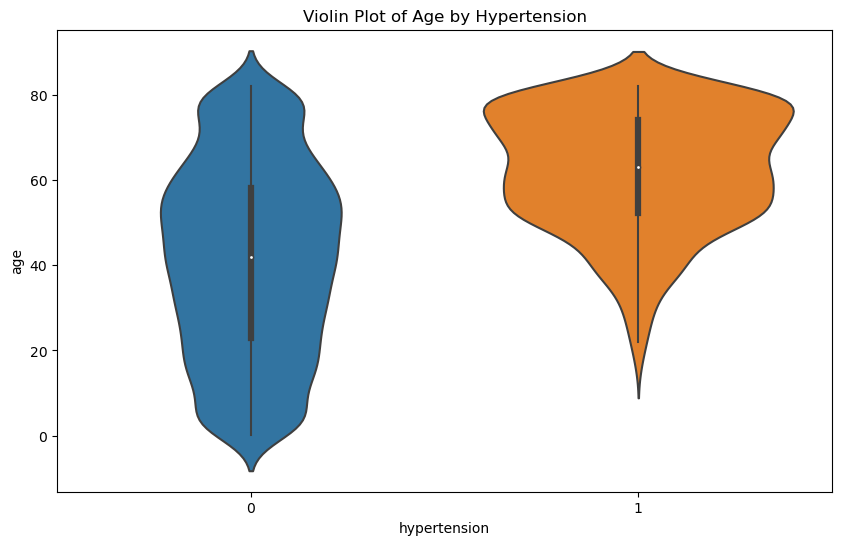

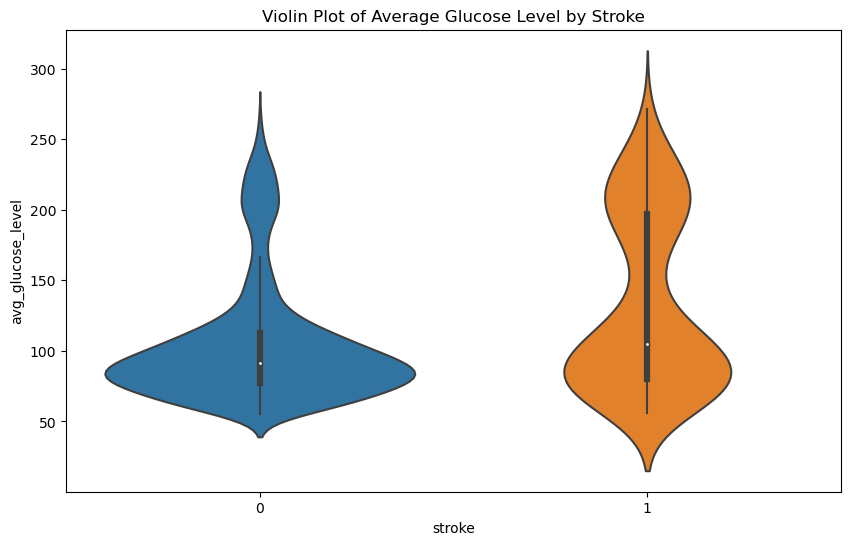

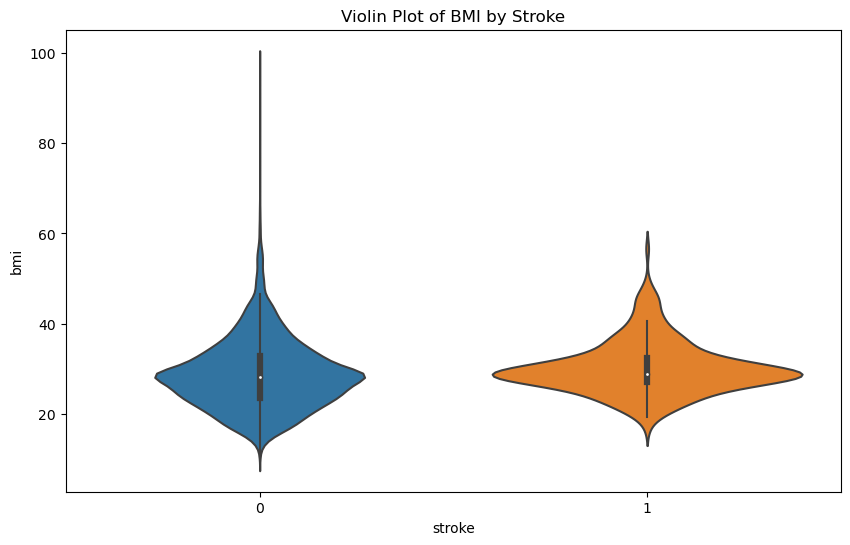

In [5]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='hypertension', y='age', data=df)
plt.title('Violin Plot of Age by Hypertension')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='stroke', y='avg_glucose_level', data=df)
plt.title('Violin Plot of Average Glucose Level by Stroke')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='stroke', y='bmi', data=df)
plt.title('Violin Plot of BMI by Stroke')
plt.show()

In [6]:

label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    return outliers

def replace_outliers(df, strategy='mean'):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        outliers = detect_outliers(df, col)
        if strategy == 'mean':
            replacement = df[col].mean()
        elif strategy == 'median':
            replacement = df[col].median()
        elif strategy == 'mode':
            replacement = df[col].mode()[0]
        df.loc[outliers, col] = replacement
    return df

df_treated = df.copy()
df_treated = replace_outliers(df_treated, strategy='mean')

print(f"Dataset shape after replacing outliers: {df_treated.shape}")

print("Class distribution in target 'stroke':")
print(df_treated['stroke'].value_counts())


Dataset shape after replacing outliers: (5110, 11)
Class distribution in target 'stroke':
stroke
0    4861
1     249
Name: count, dtype: int64


C:\Users\USER\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


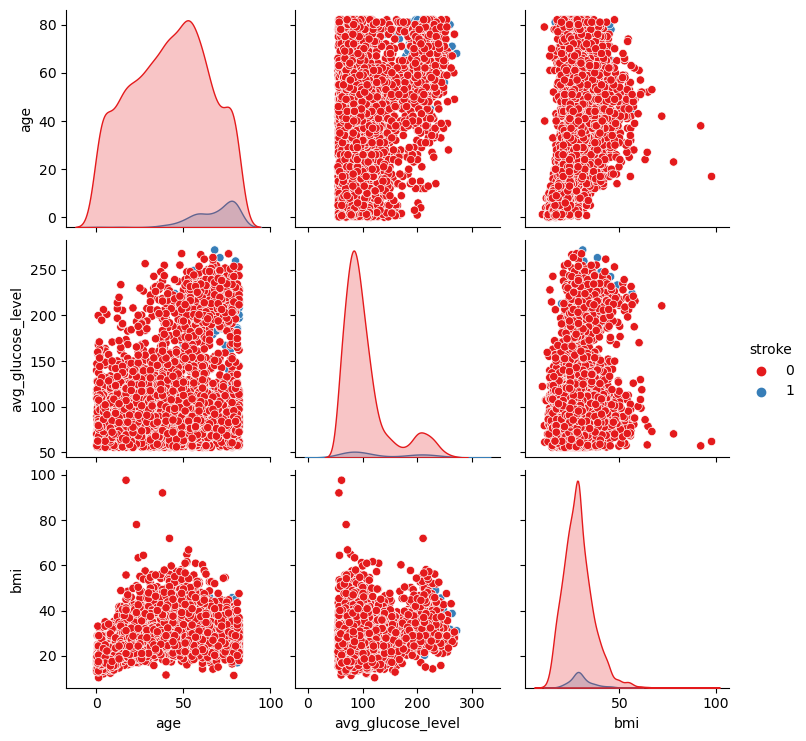

In [7]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']

sns.pairplot(df[numeric_features + ['stroke']], hue='stroke', palette='Set1')
plt.show()


In [8]:


print("Summary statistics:")
print(df.describe())

print("Class distribution:")
print(df['stroke'].value_counts())



Summary statistics:
            gender          age  hypertension  heart_disease  ever_married  \
count  5110.000000  5110.000000   5110.000000    5110.000000   5110.000000   
mean      0.414286    43.226614      0.097456       0.054012      0.656164   
std       0.493044    22.612647      0.296607       0.226063      0.475034   
min       0.000000     0.080000      0.000000       0.000000      0.000000   
25%       0.000000    25.000000      0.000000       0.000000      0.000000   
50%       0.000000    45.000000      0.000000       0.000000      1.000000   
75%       1.000000    61.000000      0.000000       0.000000      1.000000   
max       2.000000    82.000000      1.000000       1.000000      1.000000   

         work_type  Residence_type  avg_glucose_level          bmi  \
count  5110.000000     5110.000000        5110.000000  5110.000000   
mean      2.167710        0.508023         106.147677    28.893237   
std       1.090293        0.499985          45.283560     7.698018 

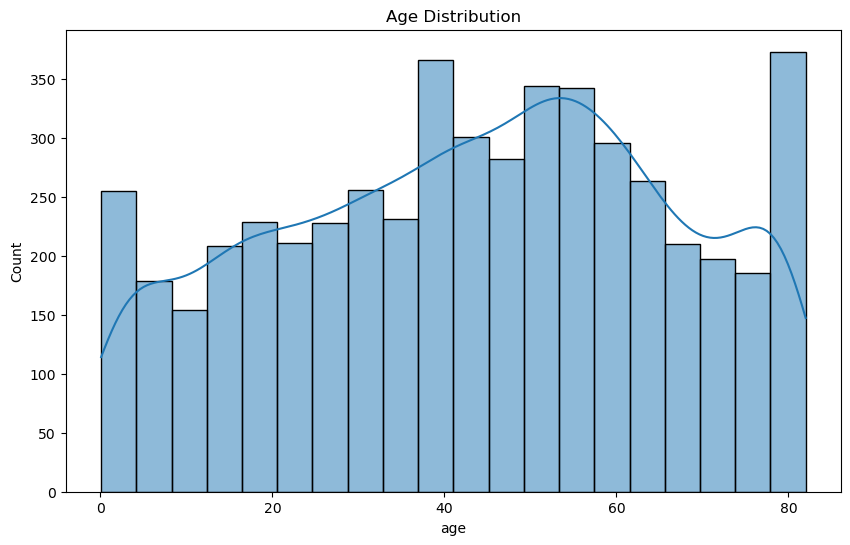

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()



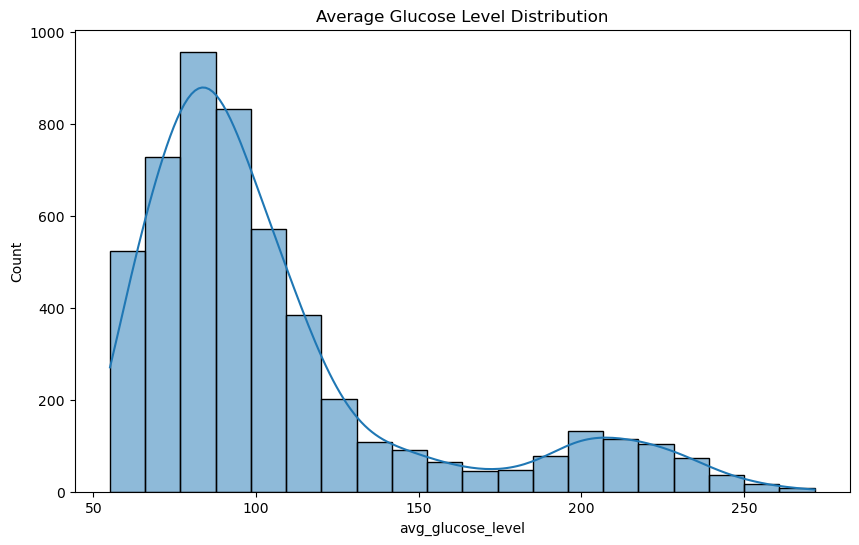

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_glucose_level'], bins=20, kde=True)
plt.title('Average Glucose Level Distribution')
plt.show()



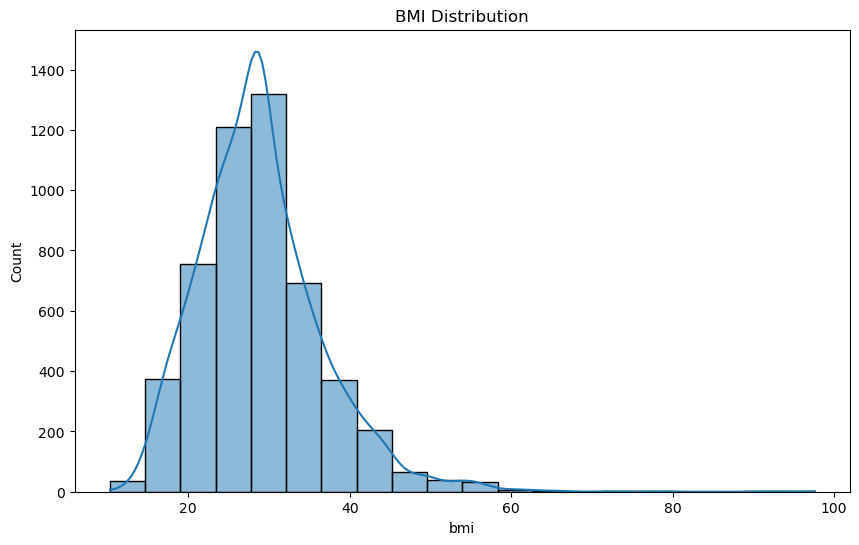

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=20, kde=True)
plt.title('BMI Distribution')
plt.show()



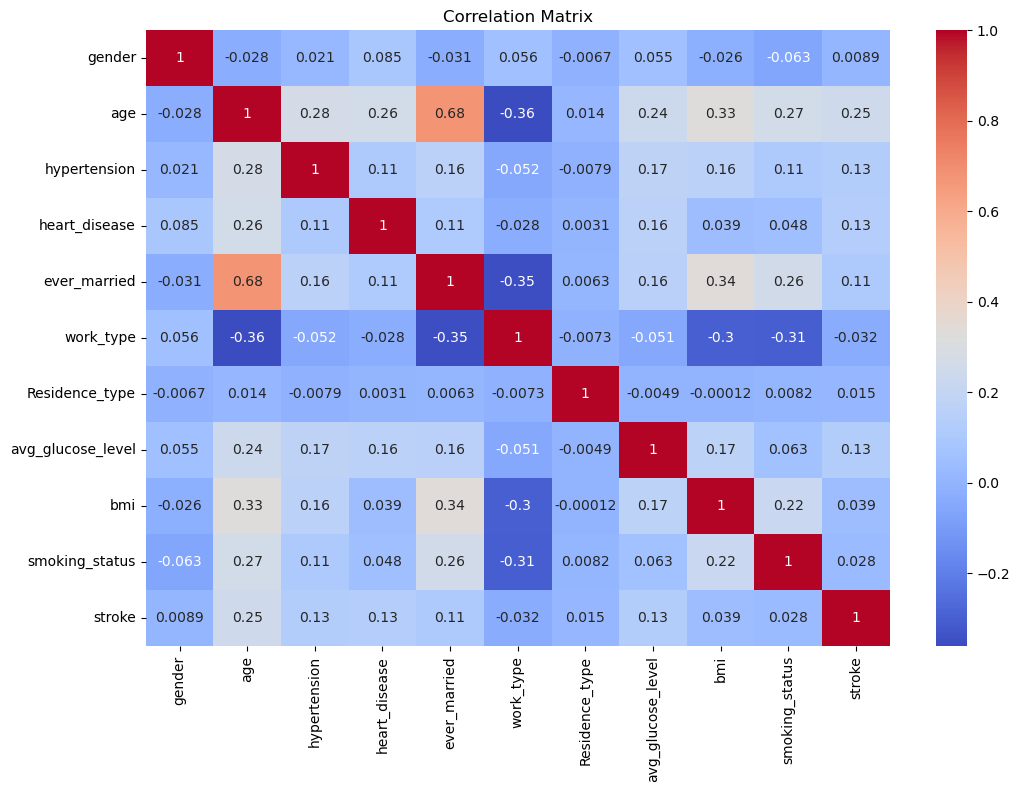

Data Exploration and Visualization completed.


In [12]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print("Data Exploration and Visualization completed.")


In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def scale_and_split(df):
    scaler = StandardScaler()
    features = df.drop('stroke', axis=1)
    target = df['stroke'].astype(int)  
    
    features_scaled = scaler.fit_transform(features)
    
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
    
    X_train = pd.DataFrame(X_train, columns=features.columns)
    X_test = pd.DataFrame(X_test, columns=features.columns)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = scale_and_split(df_treated)

print("X_train dtypes:\n", X_train.dtypes)
print("X_train dtypes:\n", X_train.describe())
print("X_train head:\n", X_train.head())
print("X_test head:\n", X_test.head())

print("Feature scaling and train-test split completed.")
print("Shapes of X_train, X_test, y_train, y_test:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print("Unique values in y_train:", np.unique(y_train, return_counts=True))
print("Unique values in y_test:", np.unique(y_test, return_counts=True))


X_train dtypes:
 gender               float64
age                  float64
hypertension         float64
heart_disease        float64
ever_married         float64
work_type            float64
Residence_type       float64
avg_glucose_level    float64
bmi                  float64
smoking_status       float64
dtype: object
X_train dtypes:
             gender          age  hypertension  heart_disease  ever_married  \
count  3577.000000  3577.000000   3577.000000    3577.000000   3577.000000   
mean      0.004026     0.004438     -0.020361       0.000989     -0.003002   
std       1.000027     0.995882      0.971894       1.002090      1.001122   
min      -0.840344    -1.904723     -0.328602      -0.238947     -1.381436   
25%      -0.840344    -0.761888     -0.328602      -0.238947     -1.381436   
50%      -0.840344     0.078432     -0.328602      -0.238947      0.723884   
75%       1.188073     0.786070     -0.328602      -0.238947      0.723884   
max       1.188073     1.714845      3

In [14]:


nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [15]:


y_pred = nb_model.predict(X_test)
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]

cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='accuracy')

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Naive Bayes Model Accuracy: {accuracy}")
print(f"Cross-Validation Accuracy: {cv_scores.mean()}")
print(f"ROC AUC Score: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{report}")

print("Model Evaluation completed.")


Naive Bayes Model Accuracy: 0.863013698630137
Cross-Validation Accuracy: 0.8736297222330742
ROC AUC Score: 0.8160851567120048
F1 Score: 0.2391304347826087
Precision: 0.17647058823529413
Recall: 0.3707865168539326
Confusion Matrix:
[[1290  154]
 [  56   33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1444
           1       0.18      0.37      0.24        89

    accuracy                           0.86      1533
   macro avg       0.57      0.63      0.58      1533
weighted avg       0.91      0.86      0.88      1533

Model Evaluation completed.


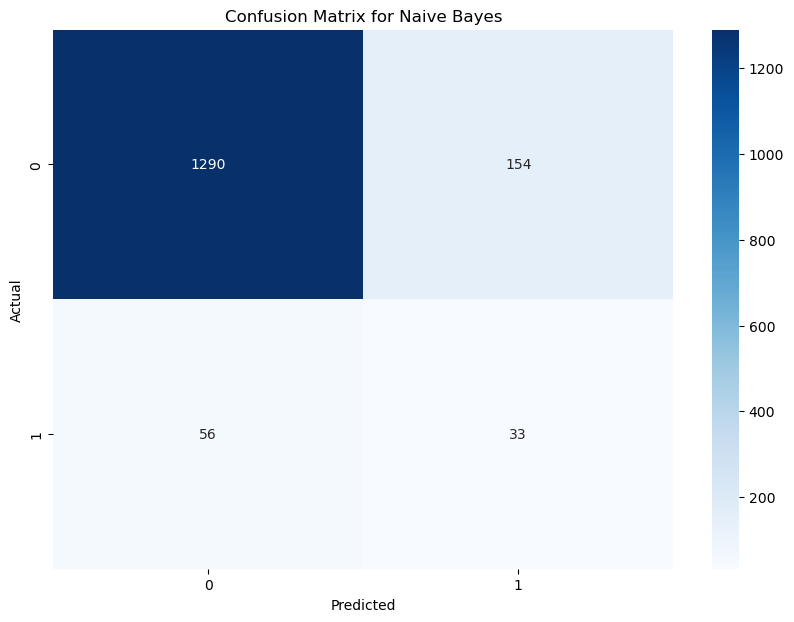

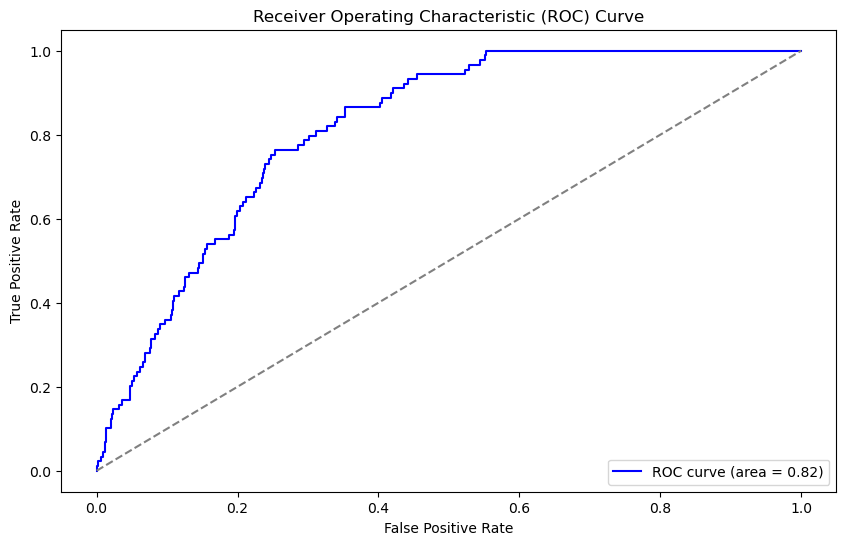

Result Visualization completed.


In [16]:


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm, 'Naive Bayes')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Result Visualization completed.")


In [17]:


param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")


Best Parameters: {'var_smoothing': 1.0}
Best Cross-validation Score: 0.928151345860843


In [18]:
best_nb_model = GaussianNB(var_smoothing=grid_search.best_params_['var_smoothing'])
best_nb_model.fit(X_train, y_train)

y_pred_tuned = best_nb_model.predict(X_test)
y_pred_prob_tuned = best_nb_model.predict_proba(X_test)[:, 1]

cv_scores_tuned = cross_val_score(best_nb_model, X_train, y_train, cv=5, scoring='accuracy')

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)

print(f"Naive Bayes Model Accuracy (Tuned): {accuracy_tuned}")
print(f"Cross-Validation Accuracy (Tuned): {cv_scores_tuned.mean()}")
print(f"ROC AUC Score (Tuned): {roc_auc_tuned}")
print(f"F1 Score (Tuned): {f1_tuned}")
print(f"Precision (Tuned): {precision_tuned}")
print(f"Recall (Tuned): {recall_tuned}")
print(f"Confusion Matrix (Tuned):\n{cm_tuned}")
print(f"Classification Report (Tuned):\n{report_tuned}")

print("Model Evaluation after Hyperparameter Tuning completed.")


Naive Bayes Model Accuracy (Tuned): 0.9197651663405088
Cross-Validation Accuracy (Tuned): 0.928151345860843
ROC AUC Score (Tuned): 0.8143966510006535
F1 Score (Tuned): 0.18543046357615894
Precision (Tuned): 0.22580645161290322
Recall (Tuned): 0.15730337078651685
Confusion Matrix (Tuned):
[[1396   48]
 [  75   14]]
Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1444
           1       0.23      0.16      0.19        89

    accuracy                           0.92      1533
   macro avg       0.59      0.56      0.57      1533
weighted avg       0.91      0.92      0.91      1533

Model Evaluation after Hyperparameter Tuning completed.


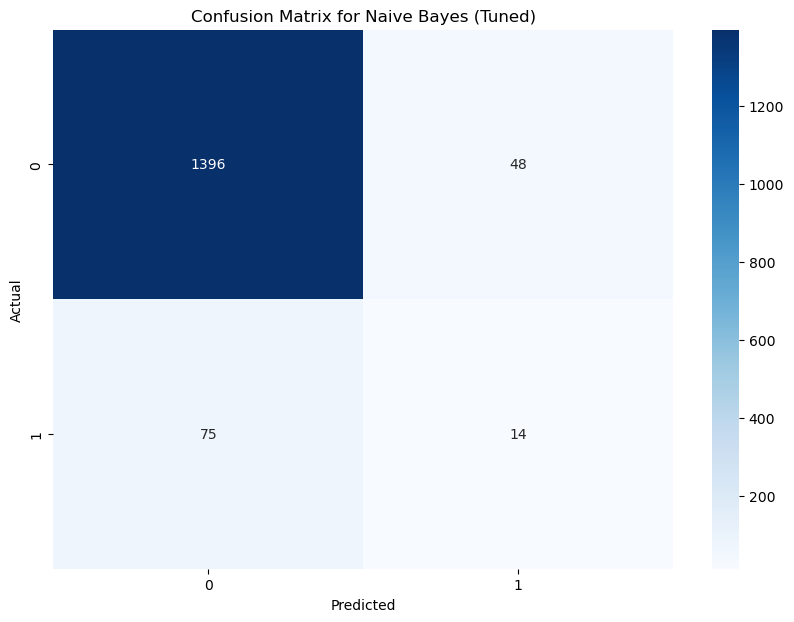

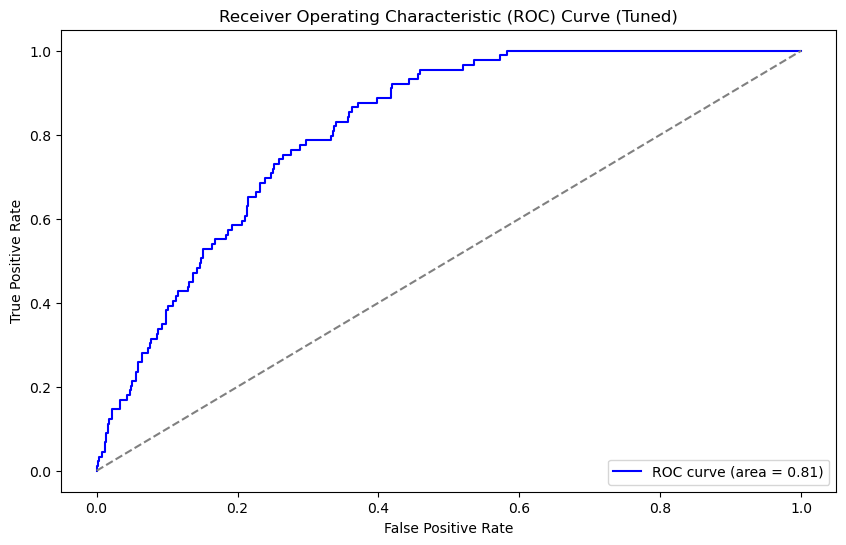

Result Visualization after Hyperparameter Tuning completed.


In [19]:


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm_tuned, 'Naive Bayes (Tuned)')

fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_prob_tuned)
plt.figure(figsize=(10, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label=f'ROC curve (area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Tuned)')
plt.legend(loc="lower right")
plt.show()

print("Result Visualization after Hyperparameter Tuning completed.")


In [20]:

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

print("Model training completed.")



Model training completed.


In [21]:

y_pred = knn_model.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"KNN Model Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{report}")

print("Model Evaluation completed.")


KNN Model Accuracy: 0.9419439008480104
ROC AUC Score: 0.617631267702076
F1 Score: 0.043010752688172046
Precision: 0.5
Recall: 0.02247191011235955
Confusion Matrix:
[[1442    2]
 [  87    2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.50      0.02      0.04        89

    accuracy                           0.94      1533
   macro avg       0.72      0.51      0.51      1533
weighted avg       0.92      0.94      0.92      1533

Model Evaluation completed.


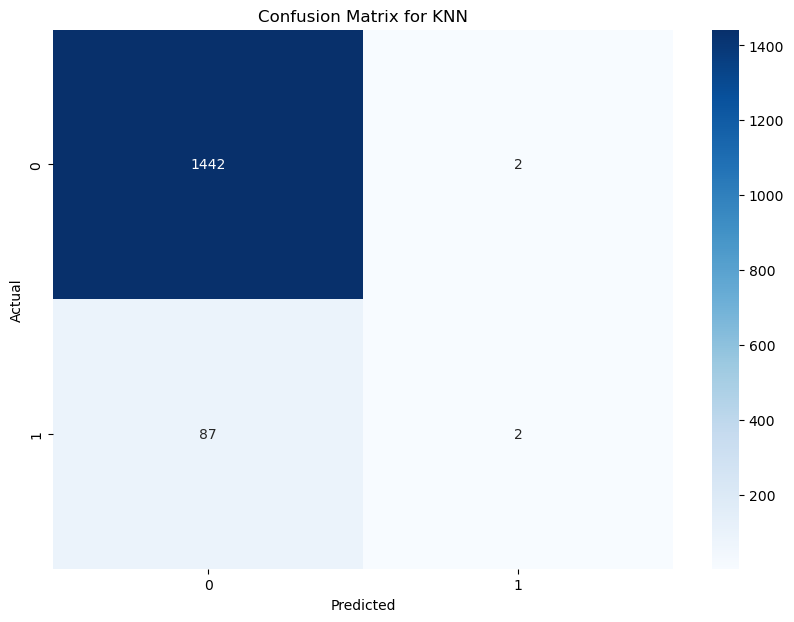

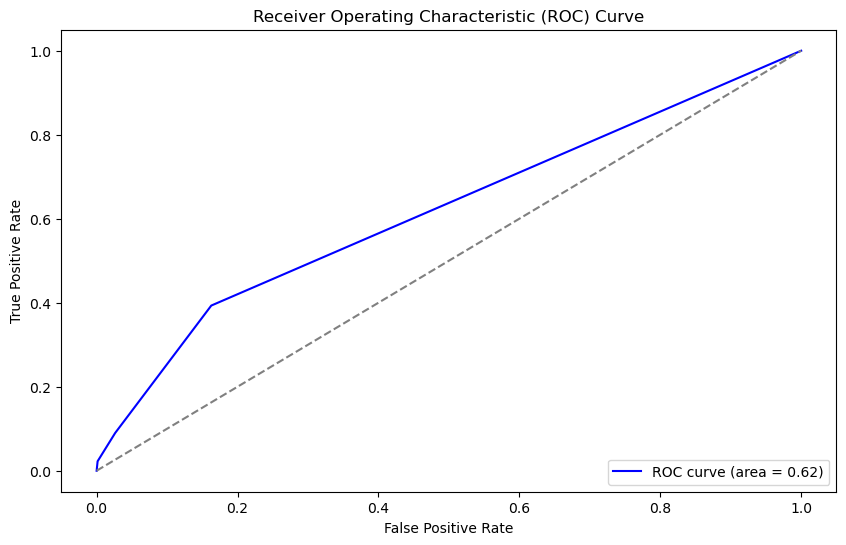

Result Visualization completed.


In [22]:


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm, 'KNN')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Result Visualization completed.")


In [23]:

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
Best Cross-validation Score: 0.9552697581747861


In [24]:
best_knn_model = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                      weights=grid_search.best_params_['weights'],
                                      metric=grid_search.best_params_['metric'])
best_knn_model.fit(X_train, y_train)

y_pred_tuned = best_knn_model.predict(X_test)
y_pred_prob_tuned = best_knn_model.predict_proba(X_test)[:, 1]

cv_scores_tuned = cross_val_score(best_knn_model, X_train, y_train, cv=5, scoring='accuracy')

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)

print(f"KNN Model Accuracy (Tuned): {accuracy_tuned}")
print(f"Cross-Validation Accuracy (Tuned): {cv_scores_tuned.mean()}")
print(f"ROC AUC Score (Tuned): {roc_auc_tuned}")
print(f"F1 Score (Tuned): {f1_tuned}")
print(f"Precision (Tuned): {precision_tuned}")
print(f"Recall (Tuned): {recall_tuned}")
print(f"Confusion Matrix (Tuned):\n{cm_tuned}")
print(f"Classification Report (Tuned):\n{report_tuned}")

print("Model Evaluation after Hyperparameter Tuning completed.")

KNN Model Accuracy (Tuned): 0.9419439008480104
Cross-Validation Accuracy (Tuned): 0.9552697581747861
ROC AUC Score (Tuned): 0.6841249338603754
F1 Score (Tuned): 0.0
Precision (Tuned): 0.0
Recall (Tuned): 0.0
Confusion Matrix (Tuned):
[[1444    0]
 [  89    0]]
Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

Model Evaluation after Hyperparameter Tuning completed.


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\s

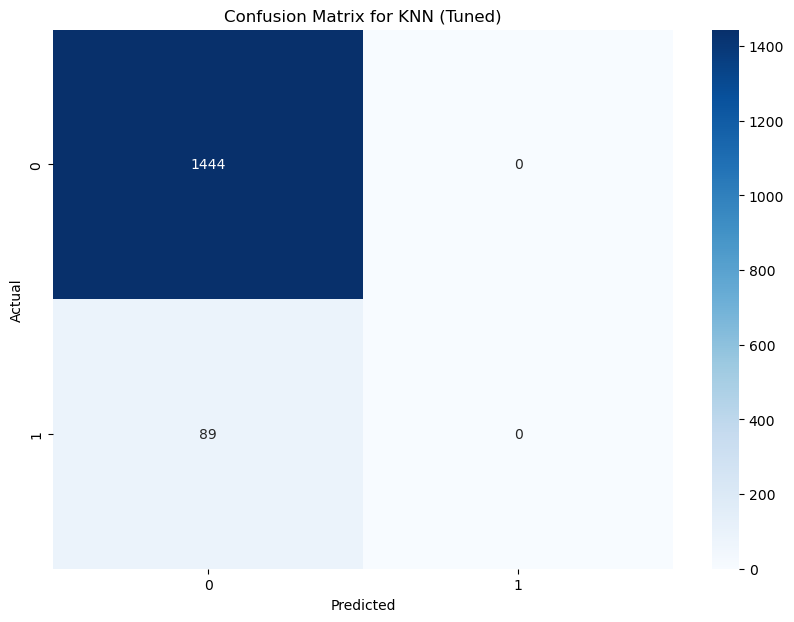

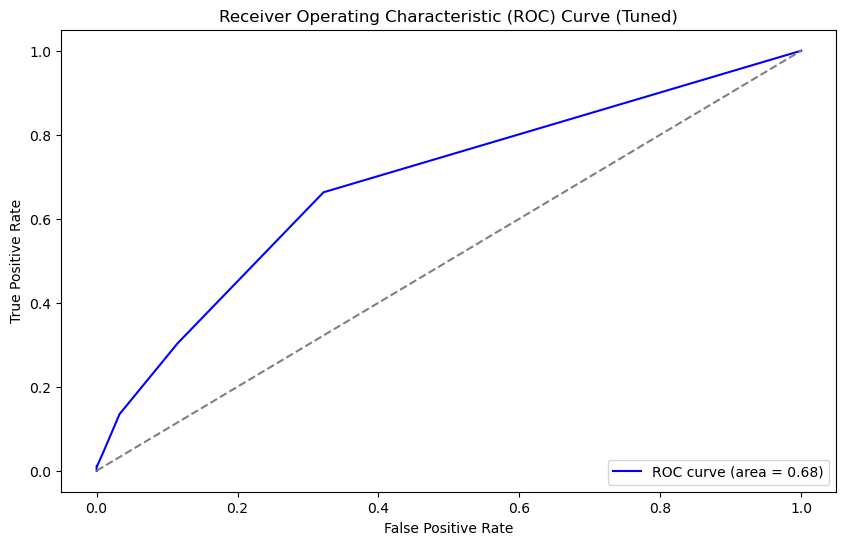

Result Visualization after Hyperparameter Tuning completed.


In [25]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm_tuned, 'KNN (Tuned)')

fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_prob_tuned)
plt.figure(figsize=(10, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label=f'ROC curve (area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Tuned)')
plt.legend(loc="lower right")
plt.show()

print("Result Visualization after Hyperparameter Tuning completed.")

In [26]:


dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [27]:

y_pred = dt_model.predict(X_test)
y_pred_prob = dt_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Decision Tree Model Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{report}")

print("Model Evaluation completed.")


Decision Tree Model Accuracy: 0.8995433789954338
ROC AUC Score: 0.5302102461950263
F1 Score: 0.11494252873563218
Precision: 0.11764705882352941
Recall: 0.11235955056179775
Confusion Matrix:
[[1369   75]
 [  79   10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1444
           1       0.12      0.11      0.11        89

    accuracy                           0.90      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.90      0.90      0.90      1533

Model Evaluation completed.


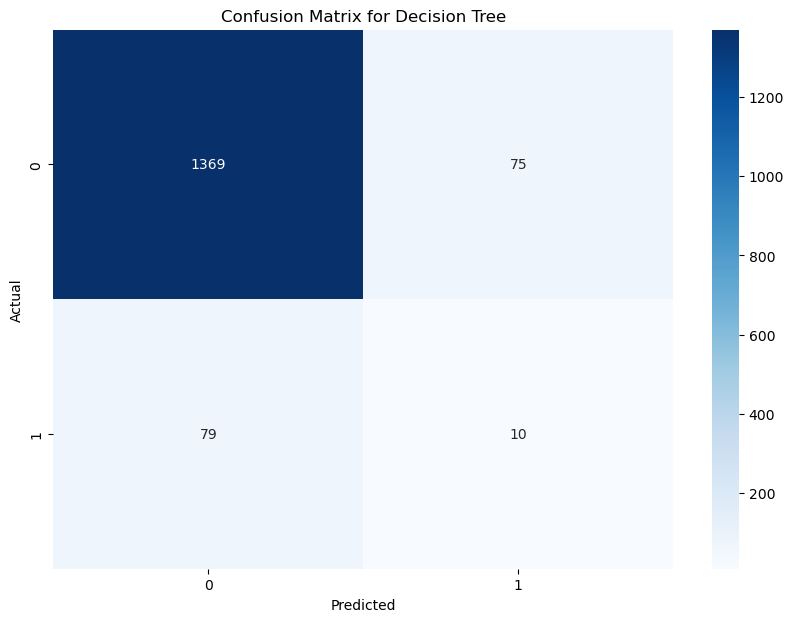

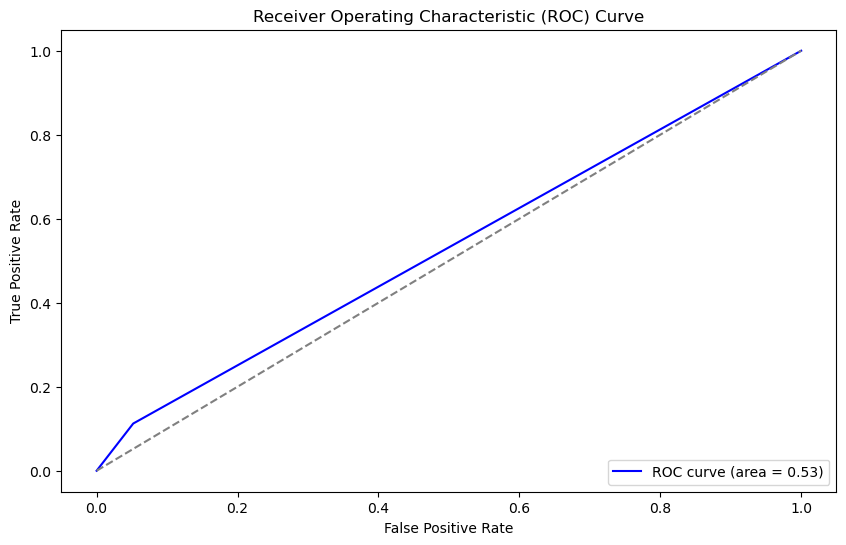

Result Visualization completed.


In [28]:


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm, 'Decision Tree')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Result Visualization completed.")


In [29]:


param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
Best Cross-validation Score: 0.9555494784545063


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\USER\anaconda3\Lib\site-packages

In [30]:
best_dt_model = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
best_dt_model.fit(X_train, y_train)

y_pred_tuned = best_dt_model.predict(X_test)
y_pred_prob_tuned = best_dt_model.predict_proba(X_test)[:, 1]

cv_scores_tuned = cross_val_score(best_dt_model, X_train, y_train, cv=5, scoring='accuracy')

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)

print(f"Decision Tree Model Accuracy (Tuned): {accuracy_tuned}")
print(f"Cross-Validation Accuracy (Tuned): {cv_scores_tuned.mean()}")
print(f"ROC AUC Score (Tuned): {roc_auc_tuned}")
print(f"F1 Score (Tuned): {f1_tuned}")
print(f"Precision (Tuned): {precision_tuned}")
print(f"Recall (Tuned): {recall_tuned}")
print(f"Confusion Matrix (Tuned):\n{cm_tuned}")
print(f"Classification Report (Tuned):\n{report_tuned}")

print("Model Evaluation after Hyperparameter Tuning completed.")

Decision Tree Model Accuracy (Tuned): 0.9399869536855838
Cross-Validation Accuracy (Tuned): 0.9555494784545063
ROC AUC Score (Tuned): 0.6926608360048554
F1 Score (Tuned): 0.02127659574468085
Precision (Tuned): 0.2
Recall (Tuned): 0.011235955056179775
Confusion Matrix (Tuned):
[[1440    4]
 [  88    1]]
Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.20      0.01      0.02        89

    accuracy                           0.94      1533
   macro avg       0.57      0.50      0.50      1533
weighted avg       0.90      0.94      0.91      1533

Model Evaluation after Hyperparameter Tuning completed.


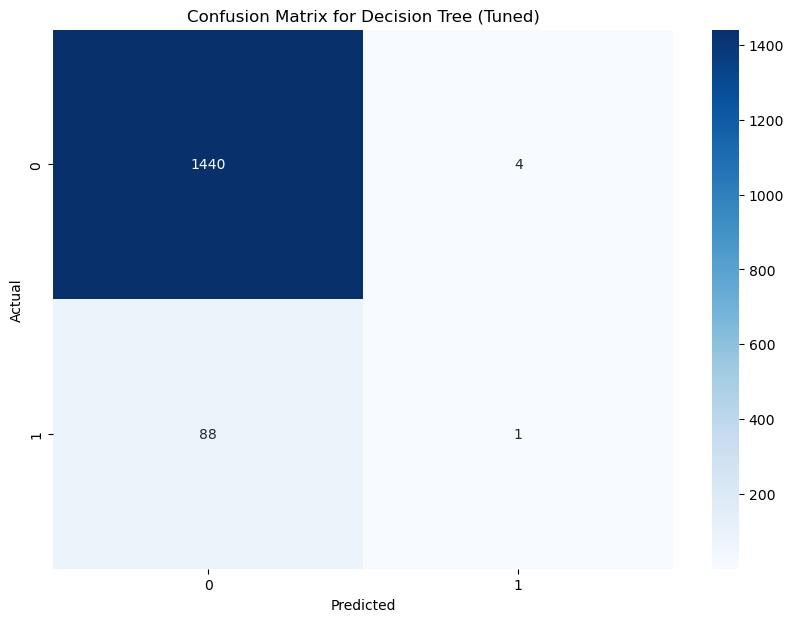

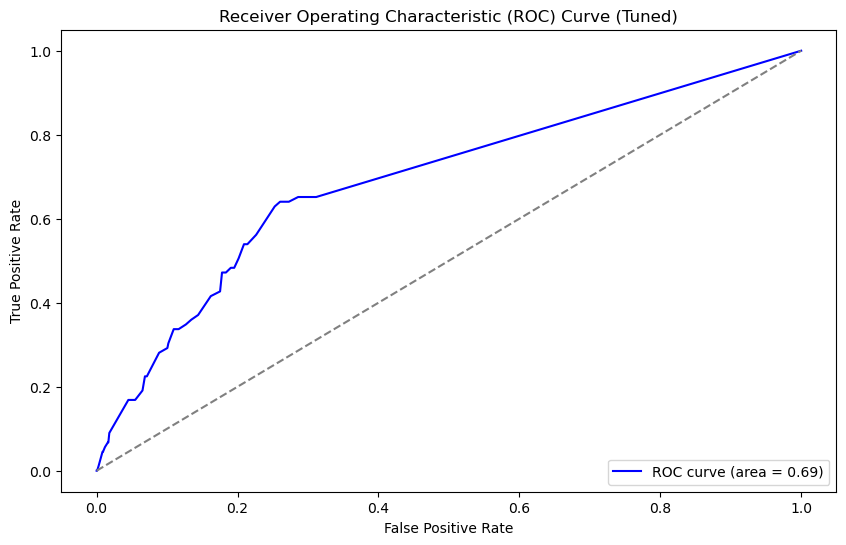

Result Visualization after Hyperparameter Tuning completed.


In [31]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm_tuned, 'Decision Tree (Tuned)')

fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_prob_tuned)
plt.figure(figsize=(10, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label=f'ROC curve (area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Tuned)')
plt.legend(loc="lower right")
plt.show()

print("Result Visualization after Hyperparameter Tuning completed.")


In [32]:
# Define the environment
class HealthEnv(gym.Env):
    def __init__(self, X, y):
        super(HealthEnv, self).__init__()
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.current_sample = 0
        self.observation_space = spaces.Discrete(self.n_samples)
        self.action_space = spaces.Discrete(2)  # Binary classification: 0 (no stroke), 1 (stroke)

    def reset(self):
        self.current_sample = 0
        return self.current_sample

    def step(self, action):
        true_label = self.y.iloc[self.current_sample]
        reward = 1 if action == true_label else -1
        self.current_sample += 1
        done = self.current_sample >= self.n_samples
        next_state = self.current_sample if not done else 0  # Ensure next state is valid
        return next_state, reward, done, {}

    def render(self, mode='human'):
        pass



In [33]:
# Q-learning parameters
step_size = 0.1
episodes = 1000
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.001

# Initialize the Q-table
n_states = X_train.shape[0]
n_actions = 2  # For binary classification (stroke or no stroke)
Q = np.zeros((n_states, n_actions))

success_episodes = 0

# Training the Q-learning model
env = HealthEnv(X_train, y_train)

for episode in range(episodes):
    state = env.reset()
    total_R = 0  # Reward count for each episode
    while True:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_state, reward, done, _ = env.step(action)
        total_R += reward

        if reward == 1 and done:
            success_episodes += 1

        if done:
            break

        old_value = Q[state, action]
        next_max = np.max(Q[next_state]) if next_state is not None else 0
        new_value = old_value + step_size * (reward + gamma * next_max - old_value)
        Q[state, action] = new_value

        state = next_state

    epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    # Print results for each episode
    print(f"Episode {episode}: ||  Total Reward: {total_R} || e-greedy: {epsilon} || Success Rate: {success_episodes}/{episode+1}")

# Determine policy from Q-table
policy = np.argmax(Q, axis=1)

# Evaluate the Q-learning model
env_test = HealthEnv(X_test, y_test)
y_pred = []
y_pred_prob = []

state = env_test.reset()
for _ in range(X_test.shape[0]):
    action = policy[state]
    y_pred.append(action)
    next_state, reward, done, _ = env_test.step(action)
    y_pred_prob.append(np.max(Q[state]))  # Append the probability score
    if done:
        break
    state = next_state

y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

Episode 0: ||  Total Reward: -17 || e-greedy: 1.0 || Success Rate: 1/1
Episode 1: ||  Total Reward: -41 || e-greedy: 0.9991004498500375 || Success Rate: 2/2
Episode 2: ||  Total Reward: 23 || e-greedy: 0.9982017988005998 || Success Rate: 2/3
Episode 3: ||  Total Reward: -41 || e-greedy: 0.9973040459530357 || Success Rate: 3/4
Episode 4: ||  Total Reward: 51 || e-greedy: 0.9964071904095924 || Success Rate: 4/5
Episode 5: ||  Total Reward: 93 || e-greedy: 0.9955112312734141 || Success Rate: 5/6
Episode 6: ||  Total Reward: 51 || e-greedy: 0.9946161676485418 || Success Rate: 6/7
Episode 7: ||  Total Reward: 85 || e-greedy: 0.9937219986399116 || Success Rate: 6/8
Episode 8: ||  Total Reward: 73 || e-greedy: 0.9928287233533546 || Success Rate: 7/9
Episode 9: ||  Total Reward: -9 || e-greedy: 0.9919363408955952 || Success Rate: 8/10
Episode 10: ||  Total Reward: 17 || e-greedy: 0.9910448503742513 || Success Rate: 8/11
Episode 11: ||  Total Reward: 93 || e-greedy: 0.9901542508978318 || Succes

In [34]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Q-learning-like Model Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{report}")

Q-learning-like Model Accuracy: 0.9106327462491846
ROC AUC Score: 0.4845388900992873
F1 Score: 0.10457516339869281
Precision: 0.125
Recall: 0.0898876404494382
Confusion Matrix:
[[1388   56]
 [  81    8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.12      0.09      0.10        89

    accuracy                           0.91      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.90      0.91      0.90      1533



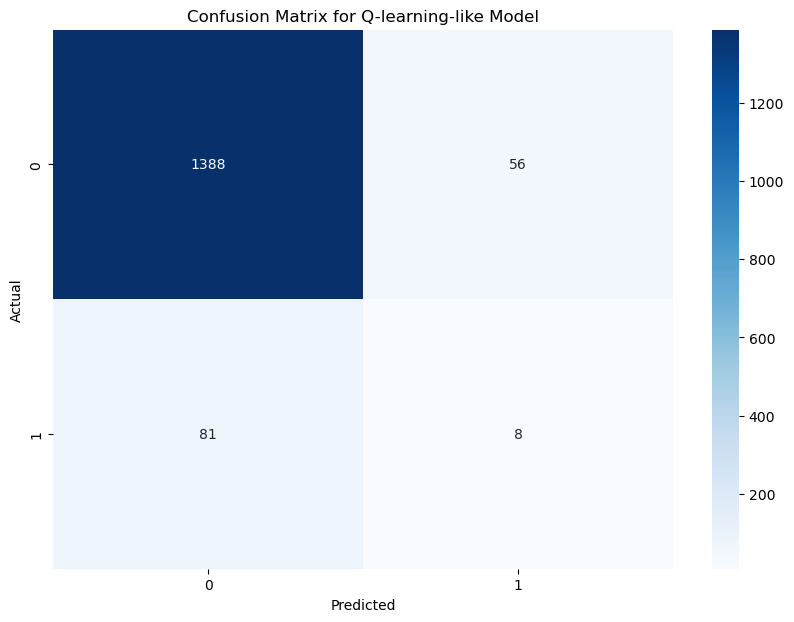

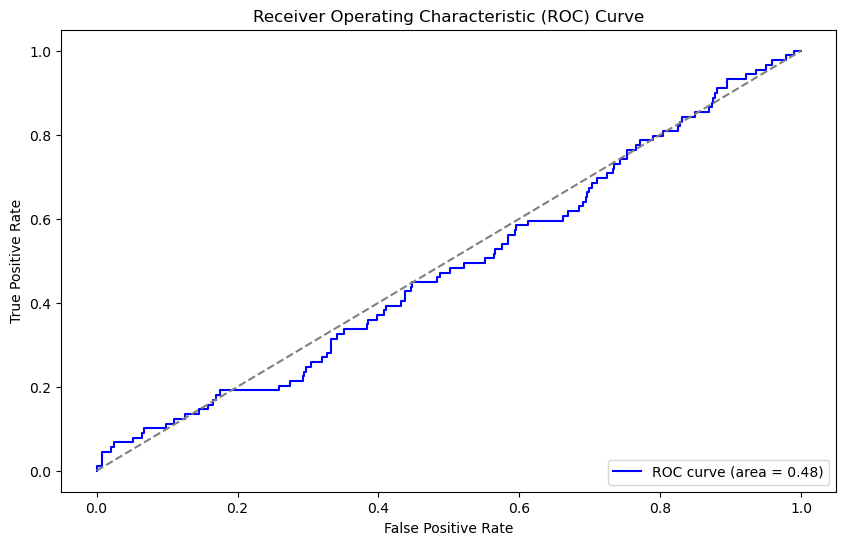

In [35]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Q-learning-like Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [36]:
from itertools import product
# Q-learning parameters
def Q_learning(env, step_size, episodes, gamma, epsilon, min_epsilon, decay_rate):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    success_episodes = 0

    for episode in range(episodes):
        state = env.reset()
        total_R = 0  # Reward count for each episode
        while True:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _ = env.step(action)
            total_R += reward

            if reward == 1 and done:
                success_episodes += 1

            if done:
                break

            old_value = Q[state, action]
            next_max = np.max(Q[next_state]) if next_state is not None else 0
            new_value = old_value + step_size * (reward + gamma * next_max - old_value)
            Q[state, action] = new_value

            state = next_state

        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

        # Print results for each episode
        print(f"Episode {episode}: ||  Total Reward: {total_R} || e-greedy: {epsilon} || Success Rate: {success_episodes}/{episode+1}")

    return Q, success_episodes

def evaluate_policy(env, policy):
    y_pred = []
    y_pred_prob = []

    state = env.reset()
    for _ in range(env.n_samples):
        action = policy[state]
        y_pred.append(action)
        next_state, reward, done, _ = env.step(action)
        y_pred_prob.append(np.max(Q[state]))  # Append the probability score
        if done:
            break
        state = next_state

    return np.array(y_pred), np.array(y_pred_prob)

# Hyperparameters grid
step_sizes = [0.1, 0.5]
episodes_list = [100, 200]
gammas = [0.8, 0.95]
min_epsilons = [0.01, 0.1]
decay_rates = [0.001, 0.01]

best_roc_auc = 0
best_params = {}

# Grid search for hyperparameter tuning
for step_size, episodes, gamma, min_epsilon, decay_rate in product(step_sizes, episodes_list, gammas, min_epsilons, decay_rates):
    env = HealthEnv(X_train, y_train)
    Q, success_episodes = Q_learning(env, step_size, episodes, gamma, 1.0, min_epsilon, decay_rate)
    policy = np.argmax(Q, axis=1)

    env_test = HealthEnv(X_test, y_test)
    y_pred, y_pred_prob = evaluate_policy(env_test, policy)

    roc_auc = roc_auc_score(y_test, y_pred_prob)

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params = {
            'step_size': step_size,
            'episodes': episodes,
            'gamma': gamma,
            'min_epsilon': min_epsilon,
            'decay_rate': decay_rate
        }

# Output the best hyperparameters
print(f"Best ROC AUC: {best_roc_auc}")
print(f"Best Parameters: {best_params}")

# Train the final model with the best hyperparameters
env = HealthEnv(X_train, y_train)
Q, success_episodes = Q_learning(env, best_params['step_size'], best_params['episodes'], best_params['gamma'], 1.0, best_params['min_epsilon'], best_params['decay_rate'])
policy = np.argmax(Q, axis=1)

env_test = HealthEnv(X_test, y_test)
y_pred, y_pred_prob = evaluate_policy(env_test, policy)



Episode 0: ||  Total Reward: -29 || e-greedy: 1.0 || Success Rate: 0/1
Episode 1: ||  Total Reward: -35 || e-greedy: 0.9990104948350412 || Success Rate: 0/2
Episode 2: ||  Total Reward: 109 || e-greedy: 0.9980219786806598 || Success Rate: 1/3
Episode 3: ||  Total Reward: -17 || e-greedy: 0.9970344505483393 || Success Rate: 2/4
Episode 4: ||  Total Reward: -21 || e-greedy: 0.9960479094505515 || Success Rate: 3/5
Episode 5: ||  Total Reward: 81 || e-greedy: 0.9950623544007555 || Success Rate: 4/6
Episode 6: ||  Total Reward: 89 || e-greedy: 0.9940777844133959 || Success Rate: 4/7
Episode 7: ||  Total Reward: -31 || e-greedy: 0.9930941985039028 || Success Rate: 5/8
Episode 8: ||  Total Reward: 71 || e-greedy: 0.99211159568869 || Success Rate: 5/9
Episode 9: ||  Total Reward: -27 || e-greedy: 0.9911299749851548 || Success Rate: 5/10
Episode 10: ||  Total Reward: 85 || e-greedy: 0.9901493354116764 || Success Rate: 6/11
Episode 11: ||  Total Reward: -15 || e-greedy: 0.9891696759876151 || Suc

In [37]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Q-learning-like Model Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{report}")

Q-learning-like Model Accuracy: 0.9106327462491846
ROC AUC Score: 0.4771701578013632
F1 Score: 0.10457516339869281
Precision: 0.125
Recall: 0.0898876404494382
Confusion Matrix:
[[1388   56]
 [  81    8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.12      0.09      0.10        89

    accuracy                           0.91      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.90      0.91      0.90      1533



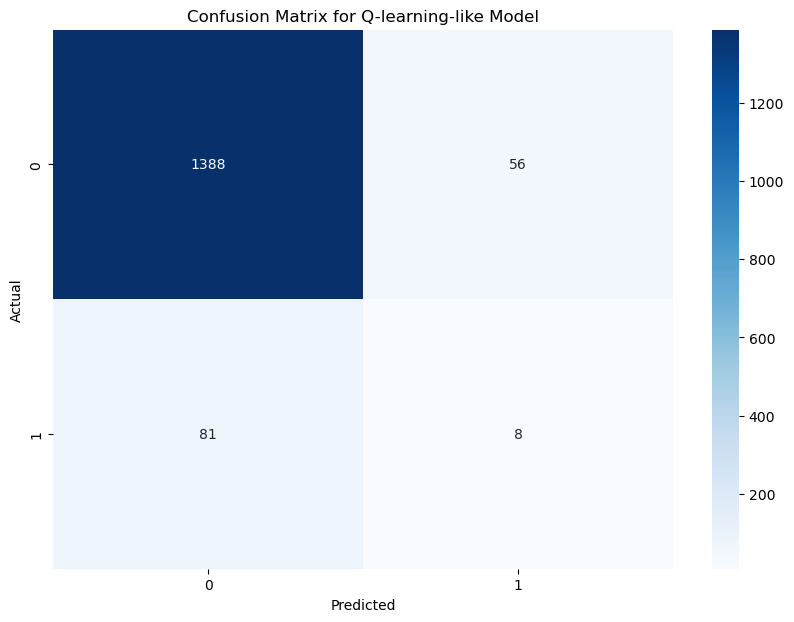

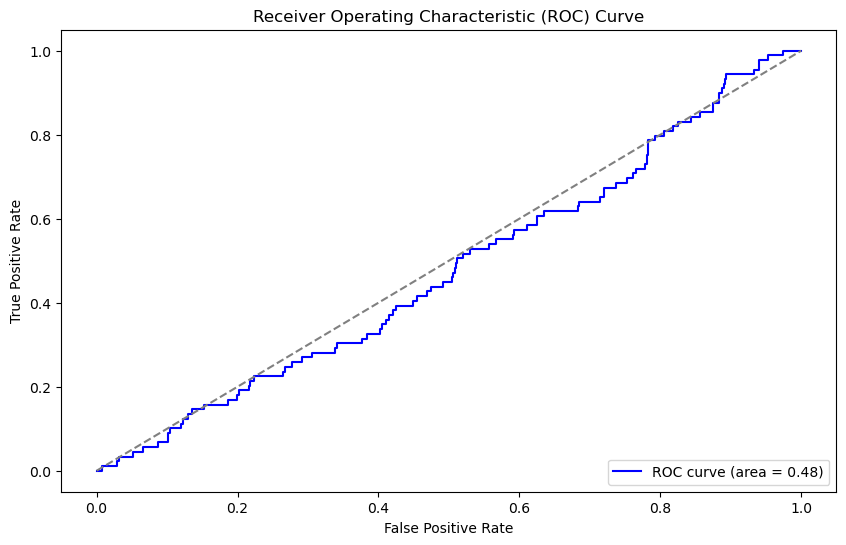

In [38]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Q-learning-like Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_test is already defined and contains the true labels

# Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_prob_nb = nb_model.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_prob_nb)

# K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)

# Q-learning-like model (using the best hyperparameters from your grid search)
# Assuming best_params is already defined and contains the best hyperparameters
env = HealthEnv(X_train, y_train)
Q, success_episodes = Q_learning(env, best_params['step_size'], best_params['episodes'], best_params['gamma'], 1.0, best_params['min_epsilon'], best_params['decay_rate'])
policy = np.argmax(Q, axis=1)

env_test = HealthEnv(X_test, y_test)
y_pred_q, y_pred_prob_q = evaluate_policy(env_test, policy)

fpr_q, tpr_q, _ = roc_curve(y_test, y_pred_prob_q)
roc_auc_q = roc_auc_score(y_test, y_pred_prob_q)



Episode 0: ||  Total Reward: -53 || e-greedy: 1.0 || Success Rate: 1/1
Episode 1: ||  Total Reward: 33 || e-greedy: 0.9910448503742513 || Success Rate: 2/2
Episode 2: ||  Total Reward: -47 || e-greedy: 0.9821788059760798 || Success Rate: 2/3
Episode 3: ||  Total Reward: 69 || e-greedy: 0.9734009801936573 || Success Rate: 3/4
Episode 4: ||  Total Reward: 119 || e-greedy: 0.9647104952370908 || Success Rate: 3/5
Episode 5: ||  Total Reward: 211 || e-greedy: 0.9561064820506426 || Success Rate: 4/6
Episode 6: ||  Total Reward: 111 || e-greedy: 0.9475880802258239 || Success Rate: 5/7
Episode 7: ||  Total Reward: 175 || e-greedy: 0.9391544379153535 || Success Rate: 6/8
Episode 8: ||  Total Reward: 173 || e-greedy: 0.9308047117479722 || Success Rate: 7/9
Episode 9: ||  Total Reward: 271 || e-greedy: 0.9225380667441053 || Success Rate: 7/10
Episode 10: ||  Total Reward: 325 || e-greedy: 0.9143536762323635 || Success Rate: 8/11
Episode 11: ||  Total Reward: 313 || e-greedy: 0.9062507217668754 ||

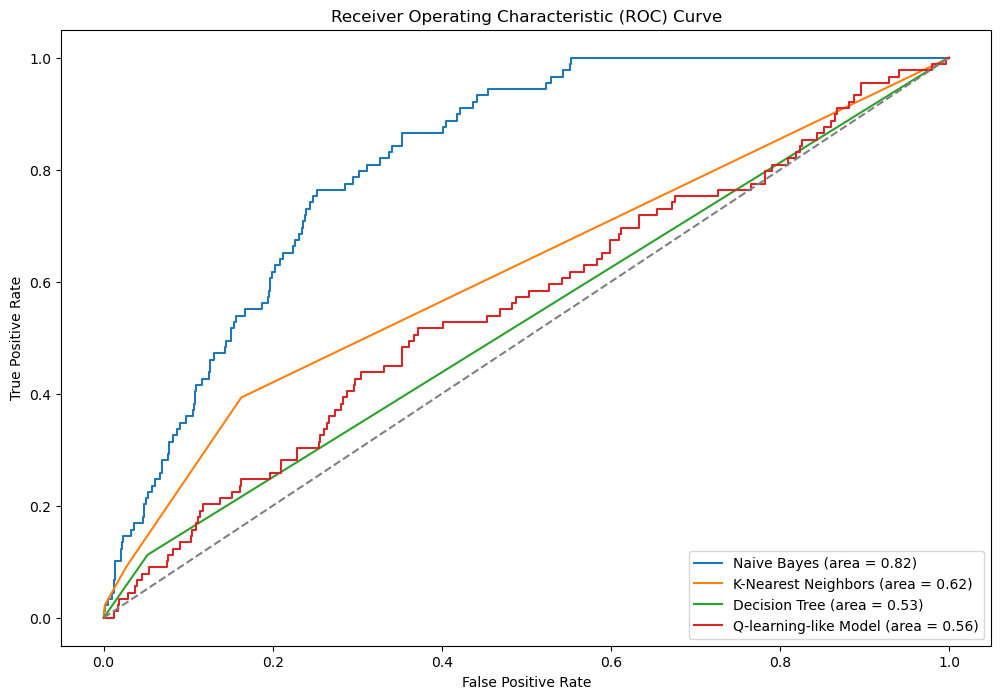

In [40]:
# Plotting the ROC curves
plt.figure(figsize=(12, 8))

plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (area = {roc_auc_nb:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (area = {roc_auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (area = {roc_auc_dt:.2f})')
plt.plot(fpr_q, tpr_q, label=f'Q-learning-like Model (area = {roc_auc_q:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
